# Preamble

In [12]:
import glob
import pathlib
import intake
import healpy as hp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import sys
sys.path.append(str(pathlib.Path.cwd() / "../../src"))
import toolbox

# Fetch Data

In [13]:
#%%
# Load Catalog
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml") 
cat_hera = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
print(f"Experiments in Catalog: {list(cat.keys())}")

#%%
# Example data
zoom_use = 8

t1 = "2020-01-01"
t2 = "2023-01-01"

t1_AMIP = "1979-01-01"
t2_AMIP = "1982-01-01"

test_data_ngc4008 = (
    cat["ICON"]["ngc4008"](time="P1D", zoom=zoom_use, chunks="auto")
    .to_dask()
    .sel(time=slice(t1, t2))
)
test_data_ngcAMIP = (
    cat["ICON.C5.AMIP_CNTL"](time="P1D", zoom=zoom_use, chunks="auto")
    .to_dask()
    .sel(time=slice(t1_AMIP, t2_AMIP))
)

ngc4008 = toolbox.attach_coords(test_data_ngc4008, test_data_ngc4008.crs.healpix_nside, True)

Experiments in Catalog: ['ICON', 'IFS', 'FESOM', 'ERA5', 'JRA3Q', 'MERRA2']


/work/mh0731/m300868/05_conda_envs/MW_env/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/mh0731/m300868/05_conda_envs/MW_env/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [14]:
#%%
# Get Pressure Data
## ERA5
slp_era5 = xr.open_dataset(
    "/work/mh0731/m300868/00_DATA/02_01.1_Spatial_Surface_Pressure/ERA5_1979to85_151.nc"
).var151
era5_slp_1979_march = slp_era5.sel(time="1979-03-01").mean(dim="time")
era5_slp_1980_march = slp_era5.sel(time="1980-03-01").mean(dim="time")
era5_slp_1981_march = slp_era5.sel(time="1981-03-01").mean(dim="time")
era5_slp_1979_july = slp_era5.sel(time="1979-07-01").mean(dim="time")
era5_slp_1980_july = slp_era5.sel(time="1980-07-01").mean(dim="time")
era5_slp_1981_july = slp_era5.sel(time="1981-07-01").mean(dim="time")
## ngcMBE2922
grid_atm = xr.open_dataset(
    "/pool/data/ICON/grids/public/mpim/0025/icon_grid_0025_R02B08_G.nc"
).rename({"clon": "lon", "clat": "lat"})
grid_oce = xr.open_dataset(
    "/pool/data/ICON/grids/public/mpim/0026/icon_grid_0026_R02B08_O.nc"
).rename({"clon": "lon", "clat": "lat"})

grid_atm["lat"] = np.rad2deg(grid_atm.lat)
grid_atm["lon"] = np.rad2deg(grid_atm.lon)
grid_atm["lon"] = (grid_atm["lon"] + 360) % 360
directory = pathlib.Path("/work/mh0287/m214002/GIT/icon-mpim-master_dbf6dad5/experiments/mbe2922")
all_files = glob.glob(f"{directory}/*")
glob_pattern = "mbe2922_atm_2d_PT3H_ml_1979"

files = sorted([str(f) for f in directory.glob(f"{glob_pattern}*")])[:]
#files
ngcMBE2922 = xr.open_mfdataset(files, combine="by_coords").rename({"ncells": "cell"}).sel(time=slice(t1_AMIP, t2_AMIP))
ngcMBE2922_slp_1979_march = (
    ngcMBE2922.psl
    .sel(time=slice("1979-03-01", "1979-03-31"))
    .mean(dim="time")
)

In [15]:
#%%
## win0000
win_exp = 'win0030'
directory = pathlib.Path(f"/work/mh0287/m300868/00_ICON/icon-mpim-master_dbf6dad5/experiments/{win_exp}")
all_files = glob.glob(f"{directory}/*")
glob_pattern = f"{win_exp}_atm_2d_PT3H_ml_1979"

files = sorted([str(f) for f in directory.glob(f"{glob_pattern}*")])[:]
#files
ngcWIN0000 = xr.open_mfdataset(files, combine="by_coords").rename({"ncells": "cell"}).sel(time=slice(t1_AMIP, t2_AMIP))
ngcWIN0000_slp_1979_march = (
    ngcWIN0000.psl
    .sel(time=slice("1979-03-01", "1979-03-31"))
    .mean(dim="time")
)

In [16]:
#%%
## ngc4MIN
directory = "/work/mh0287/m214002/GIT/icon-mpim-master_dbf6dad5/experiments/mbe2923"
file_pattern = "mbe2923_atm_2d_PT3H_ml_1979*Z.nc"
files = sorted(glob.glob(f"{directory}/{file_pattern}"))
ngc4MIN = xr.open_mfdataset(files, combine="by_coords").rename({"ncells": "cell"})
ngc4MIN_slp_1979_march = (
    ngc4MIN.psl
    .sel(time=slice("1979-03-01", "1979-03-31"))
    .mean(dim="time")
)

# Process Data

In [17]:
#%%
## Tropical ERA5
era5_slp_1979_march_tropics = (
    era5_slp_1979_march.where(toolbox.tropics(era5_slp_1979_march, -40, 40), drop=True) / 100
)
## Tropical ngcMBE2922
ngcMBE2922_slp_1979_march_tropics = (
    ngcMBE2922_slp_1979_march.where(toolbox.tropics(grid_atm, -40, 40), drop=True) / 100
)
## Tropical ngc4MIN
ngc4MIN_slp_1979_march_tropics = (
    ngc4MIN_slp_1979_march.where(toolbox.tropics(grid_atm, -40, 40), drop=True) / 100
)
## Tropical ngcWIN
ngcWIN0000_slp_1979_march_tropics = (
    ngc4MIN_slp_1979_march.where(toolbox.tropics(grid_atm, -40, 40), drop=True) / 100
)

In [18]:
#%%
## Interpolate

ngcMBE2922_slp_1979_march_tropics_remap = toolbox.interpolate_field_lon_lat(
    ngcMBE2922_slp_1979_march_tropics
)
ngc4MIN_slp_1979_march_tropics_remap = toolbox.interpolate_field_lon_lat(
    ngc4MIN_slp_1979_march_tropics
)
ngcWIN0000_slp_1979_march_tropics_remap = toolbox.interpolate_field_lon_lat(
    ngcWIN0000_slp_1979_march_tropics
)
# Original data
original_data = ngcWIN0000_slp_1979_march_tropics_remap

# Define original and new grids
lat_new = era5_slp_1979_march_tropics.lat
lon_new = era5_slp_1979_march_tropics.lon

# Use xarray's interp function for interpolation
interpolated_data = original_data.interp(lat=lat_new, lon=lon_new, method='linear')

# Create an xarray Dataset with the interpolated data
ngcWIN0000_slp_1979_march_tropics_remap_remap = xr.Dataset(
    {'data': (['lat', 'lon'], interpolated_data.data)},
    coords={
        'lat': lat_new,
        'lon': lon_new}
)
# Original data
original_data = ngcMBE2922_slp_1979_march_tropics_remap

# Define original and new grids
lat_new = era5_slp_1979_march_tropics.lat
lon_new = era5_slp_1979_march_tropics.lon

# Use xarray's interp function for interpolation
interpolated_data = original_data.interp(lat=lat_new, lon=lon_new, method='linear')

# Create an xarray Dataset with the interpolated data
ngcMBE2922_slp_1979_march_tropics_remap_remap = xr.Dataset(
    {'data': (['lat', 'lon'], interpolated_data.data)},
    coords={
        'lat': lat_new,
        'lon': lon_new}
)

# Plotting

In [19]:
#%%
## Plotting 1
SIZE = 20
plt.rcParams["axes.labelsize"] = SIZE
plt.rcParams["legend.fontsize"] = SIZE
plt.rcParams["xtick.labelsize"] = SIZE
plt.rcParams["ytick.labelsize"] = SIZE
plt.rcParams["font.size"] = SIZE
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
# Enable LaTeX font
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')

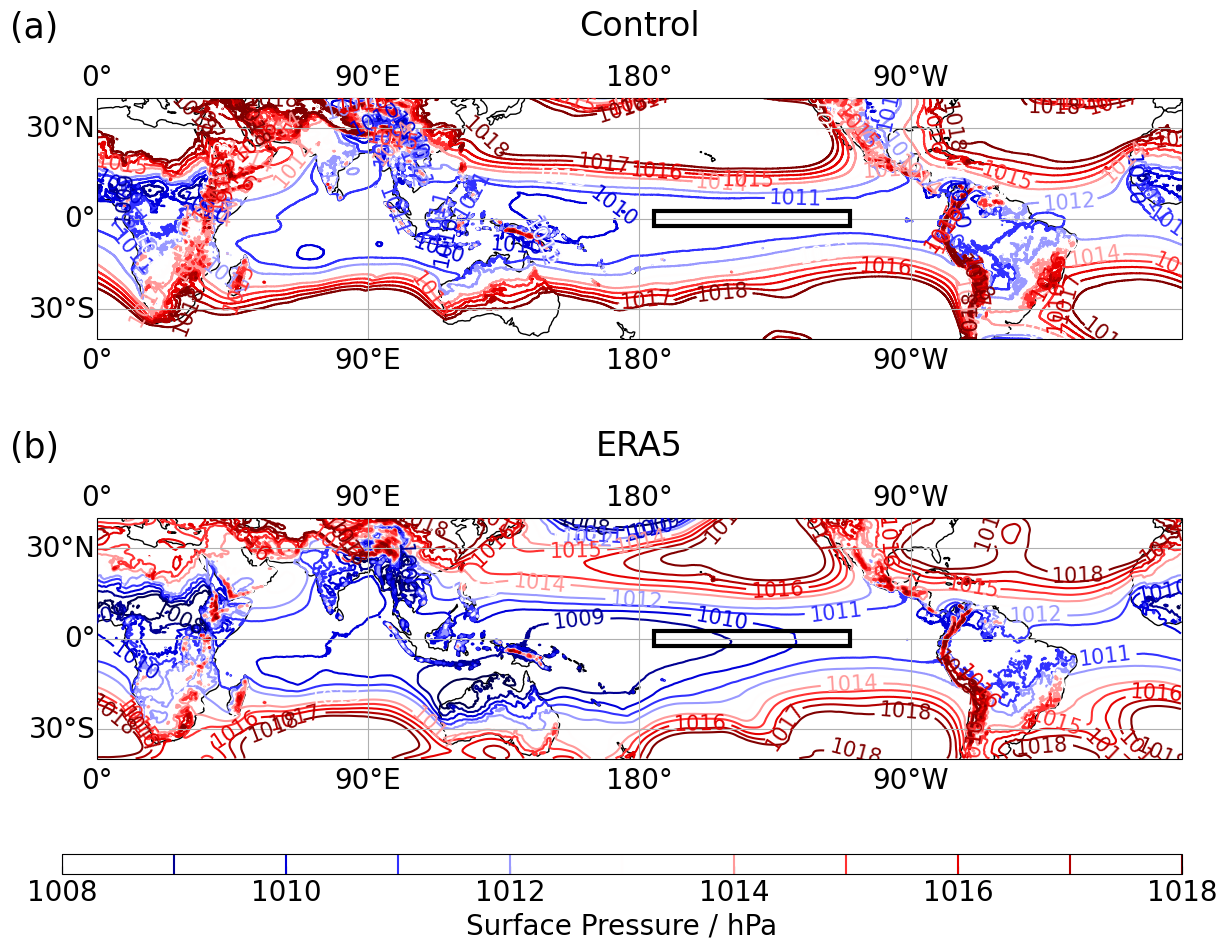

In [20]:
#%%

contour_label_size = 15
# Sample contour levels and colormap
contour_levels = [1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018]
cmap = plt.cm.seismic
norm = colors.BoundaryNorm(boundaries=contour_levels, ncolors=256)
fig = plt.figure(figsize=(14, 10))
#fig.suptitle("Surface Pressure \nMarch 1979", y=0.93)
gs = fig.add_gridspec(2, 1, hspace=0.2)  # Reduce vertical space between subplots

#####################################################################################################################
BUCHSTABI = 25
#####################################################################################################################

# Plot the first subplot
#####################################################################################################################

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
ax1.set_title("Control", pad=20)

INPUT = ngcMBE2922_slp_1979_march_tropics_remap
lon, lat = np.meshgrid(INPUT.lon, INPUT.lat)
contour1 = ax1.contour(
    lon,
    lat,
    INPUT,
    levels=contour_levels,
    cmap='seismic',
    transform=ccrs.PlateCarree(),
)
ax1.clabel(contour1, inline=True, fontsize=contour_label_size)

ax1.coastlines()
# Add degree values to x and y ticks
ax1.gridlines(draw_labels=True, xlocs=[0, 90, 180, -90], ylocs=[-30, 0, 30])
ax1.text(-0.08, 1.25, '(a)', fontsize=BUCHSTABI, transform=ax1.transAxes)
ax1.add_patch(Rectangle((5,-2.5),65,5,edgecolor='black', facecolor='None', lw=3, alpha=1, zorder=10))

# Plot the second subplot
#####################################################################################################################

ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
ax2.set_title("ERA5", pad=20)

INPUT = era5_slp_1979_march_tropics
lon, lat = np.meshgrid(INPUT.lon, INPUT.lat)
contour2 = ax2.contour(
    lon,
    lat,
    INPUT,
    levels=contour_levels,
    cmap='seismic',
    transform=ccrs.PlateCarree(),
)
ax2.clabel(contour2, inline=True, fontsize=contour_label_size)
ax2.coastlines()
ax2.gridlines(draw_labels=True, xlocs=[0, 90, 180, -90], ylocs=[-30, 0, 30])
ax2.text(-0.08, 1.25, '(b)', fontsize=BUCHSTABI, transform=ax2.transAxes)
ax2.add_patch(Rectangle((5,-2.5),65,5,edgecolor='black', facecolor='None', lw=3, alpha=1, zorder=10))

#####################################################################################################################
#####################################################################################################################

# Add colorbar
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(contour2, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Surface Pressure / hPa")

filename = f"figs/fig_01.png"
plt.savefig(filename, facecolor='white', bbox_inches='tight', dpi=200)

plt.show()
# %%